# SIIM Meeting 2021 Hands-on Session

![SIIM21](https://siim.org/resource/resmgr/siim2021/banners/SIIM2021_banner2500x600.png)

# Basics of Image Processing - Imaging quantification and registration - Session ID 6007

By the end of this presentation, you will be able to:
1. Perform image quantification based on statistical methods
2. Perform image quantification using quantitative MRI sequences
3. Perform registration of two brain MRIs

In order to accomplish the proposed activities, you will need to:

1. Have a basic understanding of python programming
2. Have a basic knowledge of DICOM

This notebook was created by João Santinha (joao.santinha@gmail.com). Revision by Felipe Kitamura (kitamura.felipe@gmail.com) and Nuno Loução (nunoloucao@gmail.com).

## 1. Image Quantification - Statistical Methods

In [1]:
import itk
import SimpleITK as sitk
import numpy as np
import itkwidgets as itkw
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
image_T1_itk = itk.imread('./brain_T1.nii.gz', itk.F)
mask_T1_itk = itk.imread('./bayesian_mask.nii.gz')

ITK also enables you to extract statistics of your images using your segmentation mask labels

In [3]:
label_stats_filter = itk.LabelStatisticsImageFilter[image_T1_itk, mask_T1_itk].New()
label_stats_filter.SetInput(image_T1_itk)
label_stats_filter.SetLabelInput(mask_T1_itk)
label_stats_filter.Update()

In [4]:
print('Label 1: min =', label_stats_filter.GetMinimum(1), '; max =', label_stats_filter.GetMaximum(1), '; mean =', label_stats_filter.GetMean(1), '; std =', label_stats_filter.GetSigma(1))
print('Label 2: min =', label_stats_filter.GetMinimum(2), '; max =', label_stats_filter.GetMaximum(2), '; mean =', label_stats_filter.GetMean(2), '; std =', label_stats_filter.GetSigma(2))
print('Label 3: min =', label_stats_filter.GetMinimum(3), '; max =', label_stats_filter.GetMaximum(3), '; mean =', label_stats_filter.GetMean(3), '; std =', label_stats_filter.GetSigma(3))
print('Label 4: min =', label_stats_filter.GetMinimum(4), '; max =', label_stats_filter.GetMaximum(4), '; mean =', label_stats_filter.GetMean(4), '; std =', label_stats_filter.GetSigma(4))

Label 1: min = 14.0 ; max = 574.0 ; mean = 254.95933143484655 ; std = 89.40513369678625
Label 2: min = 226.0 ; max = 763.0 ; mean = 436.2569736713321 ; std = 94.87566894099467
Label 3: min = 303.0 ; max = 956.0 ; mean = 595.8542034811804 ; std = 122.39659225616495
Label 4: min = 397.0 ; max = 1820.0 ; mean = 802.8540440702719 ; std = 140.25743775456513


And making use of the interface ITK <-> Numpy you can go extend your analysis to whatever you may need.

This toy example shows you how to extract the image intensities corresponding to all for labels, display them in an histogram and perform statistical tests 

In [5]:
image_T1_np = itk.GetArrayFromImage(image_T1_itk)
mask_T1_np = itk.GetArrayFromImage(mask_T1_itk)

In [6]:
intensities_label_1 = image_T1_np[mask_T1_np == 1]
intensities_label_2 = image_T1_np[mask_T1_np == 2]
intensities_label_3 = image_T1_np[mask_T1_np == 3]
intensities_label_4 = image_T1_np[mask_T1_np == 4]

In [7]:
%matplotlib inline
bins = np.linspace(0, 1200, 100)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

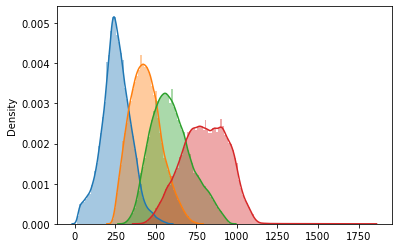

In [8]:
sns.distplot(intensities_label_1, bins=bins)
sns.distplot(intensities_label_2, bins=bins)
sns.distplot(intensities_label_3, bins=bins)
sns.distplot(intensities_label_4, bins=bins)

In [9]:
ks_test, p_value = stats.ks_2samp(intensities_label_3, intensities_label_4)
print('KS-test:', ks_test, '\np-value', p_value)

KS-test: 0.557067414323915 
p-value 0.0


## 2. Image Quantification - MRI Parametric Maps
### Making MRI quantitative

In this case we will use the .dcm files located in the Dwi_Brain folder. These are were acquired using a Diffusion Weighted sequence in which several volumes of the body part being studied are acquired with different b-values, allowing the computation of parametric maps [more on the method and clinical use](https://radiopaedia.org/articles/diffusion-weighted-imaging-1). 

The sequence contained in the Dwi_Brain folder contains 2(b=0 and b=1000) x 25 slices (3D volume), and we will use it to calculate the Apparent Diffusion Coefficient (ADC) parametric map.

\begin{equation*}
S_{b=1000} = S_{b=0} \cdot exp(-b \cdot ADC)
\end{equation*}
which can be rearranged to obtained the ADC as follows
\begin{equation*}
ADC = -\frac{ln(\frac{S_{b=1000}}{S_{b=0}})}{b}
\end{equation*}

The name of b-value dicom attribute is DiffusionBValue and the tag is (0018,9087). 

So first lets get all the .dcm files in the Dwi_Brain folder and separate them by b-value in order to create the $S_{b=0}$ and $S_{b=1000}$ volumes.

In [10]:
import os
import pydicom
dwi_dcm_dir = './Dwi_Brain'

## Get list of .dcm files in specified folder and ordered
namesGenerator = itk.GDCMSeriesFileNames.New()
namesGenerator.SetUseSeriesDetails(True)
namesGenerator.AddSeriesRestriction("0008|0021")
namesGenerator.SetGlobalWarningDisplay(False)
namesGenerator.SetDirectory(dwi_dcm_dir)

seriesUID = namesGenerator.GetSeriesUIDs()
dicom_names = namesGenerator.GetFileNames(seriesUID[0])
# dicom_names = [os.path.join(dwi_dcm_dir, file) for file in os.listdir(dwi_dcm_dir) if '.dcm' in file]

b0_dcms_list = []
b1000_dcms_list = []
for filename in dicom_names:
    if pydicom.dcmread(filename)[0x18,0x9087].value == 0:
        b0_dcms_list.append(filename)
    else:
        b1000_dcms_list.append(filename)

Using these two lists of .dcm files, corresponding to the two b-value, we can create the 3D $b_0$ and the $b_{1000}$ volumes.

In [39]:
dicomIO = itk.GDCMImageIO.New()

reader_itk = itk.ImageSeriesReader[itk.Image.F3].New()
reader_itk.SetImageIO(dicomIO)
reader_itk.SetFileNames(b0_dcms_list)
reader_itk.ForceOrthogonalDirectionOff()
reader_itk.Update()

b0_image = reader_itk.GetOutput()

# create a float version of our b0 image for the registration step
castImageFilter = itk.CastImageFilter[b0_image, itk.Image.F3].New(b0_image)
castImageFilter.Update()
b0_image_float = castImageFilter.GetOutput()

## We can reuse an instanciated filter
reader_itk2 = itk.ImageSeriesReader[itk.Image.F3].New()
reader_itk2.SetImageIO(dicomIO)
reader_itk2.ForceOrthogonalDirectionOff()
reader_itk2.SetFileNames(b1000_dcms_list)
reader_itk2.Update()
b1000_image = reader_itk2.GetOutput()

itkw.checkerboard(b0_image, b1000_image, cmap='Grayscale', mode='z', pattern=6)

Now, using both images and filters we can compute the ADC parametric map

In [38]:
b = 1000.0 # s/mm²

division_filter = itk.DivideImageFilter[itk.Image.F3, itk.Image.F3, itk.Image.F3].New()
division_filter.SetInput1(b1000_image)
division_filter.SetInput2(b0_image)
division_filter.Update()

b1000_div_b0_image = division_filter.GetOutput()

log_filter = itk.LogImageFilter[itk.Image.F3, itk.Image.F3].New()
log_filter.SetInput(b1000_div_b0_image)
log_filter.Update()

ln_b1000_div_b0_image = log_filter.GetOutput()

division_filter2 = itk.DivideImageFilter[itk.Image.F3, itk.Image.F3, itk.Image.F3].New()
division_filter2.SetInput1(ln_b1000_div_b0_image)
division_filter2.SetConstant2(-1. * b / 1e6) # 10−6 mm2 /s
division_filter2.Update()

ADC_image = division_filter2.GetOutput()

## infinit values will prevent us from correctly view the image so we will have to threshold it
threshold_filter = itk.ThresholdImageFilter[itk.Image.F3].New()
threshold_filter.SetInput(ADC_image)
threshold_filter.SetLower(0.0)
threshold_filter.SetUpper(6000.0)
threshold_filter.SetOutsideValue(0.)
threshold_filter.Update()

ADC_image = threshold_filter.GetOutput()

itkw.view(ADC_image, cmap='Grayscale', mode='z')

TypeError: Expecting argument of type itkImageF3 or itkImageSourceIF3.
Additional information:
Wrong number or type of arguments for overloaded function 'itkBinaryGeneratorImageFilterIF3IF3IF3_SetInput1'.
  Possible C/C++ prototypes are:
    itkBinaryGeneratorImageFilterIF3IF3IF3::SetInput1(itkImageF3 const *)
    itkBinaryGeneratorImageFilterIF3IF3IF3::SetInput1(itkSimpleDataObjectDecoratorF const *)
    itkBinaryGeneratorImageFilterIF3IF3IF3::SetInput1(float const &)


#### Exercise 2

Using the lists **b0_dcms_list** and **b1000_dcms_list** use the SimpleITK **ImageSeriesReader** function to read the **b0** and **b1000** images and then use **/** and * to perform the division and multiplication operations

In [18]:
## use this code box to write your solution



In [19]:



















import math
reader_b0 = sitk.ImageSeriesReader()
reader_b0.SetFileNames(b0_dcms_list)
b0_image = reader_b0.Execute()

reader_b1000 = sitk.ImageSeriesReader()
reader_b1000.SetFileNames(b1000_dcms_list)
b1000_image = reader_b1000.Execute()

b1000_div_b0_image = b1000_image/b0_image

adc_image = sitk.Log(b1000_div_b0_image)/(-1. * b / 1e6)

adc_image = sitk.Threshold(adc_image, lower=0, upper=6000, outsideValue=0)

itkw.view(sitk.Cast(adc_image, sitk.sitkFloat32), cmap='Grayscale', mode='z')

Viewer(cmap=['Grayscale'], geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itk.…

## 3. Image Registrationn
### Aligning two images (these two images may be from the same patient or not and from the same or different modalities)

In this case we will use the .dcm files located in the Dwi_Brain folder. These are were acquired using a Diffusion Weighted sequence in which several volumes of the body part being studied are acquired with different b-values, allowing the computation of parametric maps [more on the method and clinical use](https://radiopaedia.org/articles/diffusion-weighted-imaging-1). 

The sequence contained in the Dwi_Brain folder contains 2(b=0 and b=1000) x 25 slices (3D volume), and we will use it to calculate the Apparent Diffusion Coefficient (ADC) parametric map.

In [43]:
# Import Default Parameter Map
parameter_object = itk.ParameterObject.New()
parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
parameter_map_affine = parameter_object.GetDefaultParameterMap('affine')
parameter_map_bspline = parameter_object.GetDefaultParameterMap('bspline')
parameter_object.AddParameterMap(parameter_map_rigid)
parameter_object.AddParameterMap(parameter_map_affine)
parameter_object.AddParameterMap(parameter_map_bspline)

In [44]:
result_image, result_transform_parameters = itk.elastix_registration_method(
    b0_image_float, image_T1_itk,
    parameter_object=parameter_object,
    number_of_threads=8,
    log_to_console=False)

In [46]:
itkw.checkerboard(result_image, b0_image_float, cmap='Grayscale', mode='z', pattern=6)

In [49]:
parameter_object = itk.ParameterObject.New()
parameter_map_rigid = parameter_object.GetDefaultParameterMap('rigid')
parameter_map_affine = parameter_object.GetDefaultParameterMap('affine')
# For the bspline default parameter map, two extra arguments can be specified that define number of resolutions and the final bspline grid spacing in physical space.
parameter_map_bspline = parameter_object.GetDefaultParameterMap('bspline', 4, 50.0)
# to change parameters can do the followinng as well
#parameter_map_bspline['MaximumNumberOfIterations'] = ['512']
#parameter_map_bspline['NumberOfSpatialSamples'] = ['4096']
parameter_object.AddParameterMap(parameter_map_rigid)
parameter_object.AddParameterMap(parameter_map_affine)
parameter_object.AddParameterMap(parameter_map_bspline)

result_image, result_transform_parameters = itk.elastix_registration_method(
    b0_image_float, image_T1_itk,
    parameter_object=parameter_object,
    number_of_threads=8,
    log_to_console=False)

itkw.checkerboard(result_image, b0_image, cmap='Grayscale', mode='z', pattern=6)

In [50]:
# here the 'ResampleInterpolator' of all parameter maps is in the parameter_object set to FinalNearestNeighborInterpolator
result_transform_parameters.SetParameter("ResampleInterpolator", "FinalNearestNeighborInterpolator")
castImageFilter = itk.CastImageFilter[mask_T1_itk, itk.Image.F3].New(mask_T1_itk)
castImageFilter.Update()
mask_T1_itk_float = castImageFilter.GetOutput()
transformix_object = itk.TransformixFilter.New(mask_T1_itk_float)
transformix_object.SetTransformParameterObject(result_transform_parameters)

# Update object (required)
transformix_object.UpdateLargestPossibleRegion()

# Results of Transformation
result_image_transformix = transformix_object.GetOutput()

In [47]:
itkw.checkerboard(result_image_transformix, ADC_image, cmap='Grayscale', mode='z', pattern=6)

In [52]:
itkw.compare(result_image_transformix, ADC_image, link_cmap=True, cmap='Grayscale', mode='z')

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=True, description='cmap'), Checkbox(va…